In [ ]:
# Code for the paper "Quantifying Language Evolution with Transcriptions Only"

# 1. Loading Data

In [1]:
import numpy as np
import pandas as pd
from utils import calculate_zero_fraction, sparse_phonemes, sparsity, Levenshtein_distance, plot_length_distribution, haversine_distance

# Processing the mono_csv data
# The mono_csv format is as follows:
#   point,0001多,0002拖,0003大
#   01004,t ɔ 55,th ɔ 55,t ai
#
# Tasks:
# 1. Represent column names uniquely in column_name_dict as {num: feature_name}. <- 调查字表映射
# 2. Store all unique values of each column's features in string_feature_dict.  <- [num_region, vocab]
# 3. Save each row's unique key in language_key_dict as {num: language_name}.  <- 地区映射
# 4. Store all language features in language_feature as a numpy array [num_language, num_feature],
#    where (i, j) indicates that the ith language's jth feature is the language_feature(i, j)th item in string_feature_dict[j].

# 数据.csv
mono_file = '....csv'
# 划类数据，地理数据
points_file = '....csv'

# Reading the CSV file
df = pd.read_csv(mono_file)

# Creating a dictionary for column names with their corresponding index
column_name_dict = {column: index for index, column in enumerate(df.columns)}

# Creating a dictionary for language keys with their corresponding row number
language_key_dict = {df.iloc[i, 0]: i for i in range(len(df))}

dialects_speeches = [list(row[1:]) for index, row in df.iterrows()]

print(len(dialects_speeches))
print(len(dialects_speeches[0]))

1289
1000


In [2]:
key2language = {}
for language in language_key_dict.keys():
    key2language[language_key_dict[language]] = language
    
df = pd.read_csv(points_file)

geo_data_dict = {}
for index, row in df.iterrows():
    geo_data_dict[row['point']] = {
        'area': row['area'],
        'eastLongitude': row['eastLongitude'],
        'northLatitude': row['northLatitude']
    }

In [3]:
language_distance = np.zeros((len(dialects_speeches), 2))

for dialect_name in geo_data_dict:
    if dialect_name in language_key_dict.keys():
        index = language_key_dict[dialect_name]
        language_distance[index][0], language_distance[index][1]  = geo_data_dict[dialect_name]['eastLongitude'], geo_data_dict[dialect_name]['northLatitude']

In [4]:
def load_file(dir, type='dict'):
    """
    加载文件，支持type: list, dict, numpy, torch
    """
    if type == 'dict':
        with open(dir, 'r') as json_file:
            return json.load(json_file)
    elif type == 'list':
        with open(dir, 'r') as file:
            return [line.strip() for line in file]
    elif type == 'numpy':
        return np.load(dir)
    elif type == 'torch':
        return torch.load(dir)
    else:
        raise ValueError("Unsupported type: {}".format(type))


# 2. Phonetic Transcription-based Distance

In [5]:
# 删除 - (代表无记录)，？(停顿标记) 等特殊字符; 并进一步将复合音素解析为单一音素

# special_characters = ['˥', '˦', '˧', '˨', '˩', '̃', '¤', 'Ǿ', '-', '\x8d', '）', '无', '？', '\uf179', '͊', ')', '（', '̥', '̱', 'ɱ', 'ʈ', 'ᴂ', 'k', 'u', 'ĩ', 't', 'ʑ', 'c', 'ð', '\x8d', '̍', 'ᴀ', 'ʨ', '\uf179', '͊', '2', ')']

# 准备处理复合音素的字典

special_characters = [ '-', '\x8d', '）', '无', '？', '\uf179', '͊', ')', '（', '̥', '̱', '\x8d', '̍', '\uf179', ')']

compound_phonemes = {
    'ᴇn': ['ᴇ', 'n'],
    'oᴀʔ': ['o', 'ᴀ'],
    'iu': ['i', 'u'],
    'yuŋ': ['y', 'uŋ'],
    'uᴇn': ['u', 'ᴇn'],
    'iɑŋ': ['i', 'ɑŋ'],
    'uei': ['u', 'ei'],
    'uɔi': ['u', 'ɔi'],
    'ieʔ': ['ie'],
    'ɤu': ['ɤ', 'u'],
    'iai': ['i', 'ai'],
    'ioʔ': ['io'],
    'uø': ['u', 'ø'],
    'iət': ['i', 'ət'],
    'iɑɯ': ['i', 'ɑɯ'],
    'iep': ['ie', 'p'],
    'uɤŋ': ['u', 'ɤŋ'],
    'oᴀŋ': ['o', 'ᴀŋ'],
    'yɛ̃': ['y', 'ɛ̃'],
    'yɔʔ': ['y', 'ɔ'],
    'iɑ': ['i', 'ɑ'],
    'yᴇn': ['y', 'ᴇn'],
    'ɑɯ': ['ɑ', 'ɯ'],
    'əɯ': ['ə', 'ɯ'],
    'əu': ['ə', 'u'],
    'uot': ['u', 'ot'],
    'øʏ': ['ø', 'ʏ'],
    'ioŋ': ['io', 'ŋ'],
    'uɑŋ': ['u', 'ɑŋ'],
    'iɑo': ['i', 'ɑo'],
    'uoŋ': ['uo', 'ŋ'],
    'uɔ': ['u', 'ɔ'],
    'ɤŋ': ['ɤ', 'ŋ'],
    'ɔi': ['ɔ', 'i'],
    'iɑŋ': ['i', 'ɑŋ'],
    'iɤu': ['i', 'ɤu'],
    'yɤŋ': ['y', 'ɤŋ'],
    'iᴇn': ['i', 'ᴇn'],
    'ɜu': ['ɜ', 'u'],
    'iɑʔ': ['i', 'ɑ'],
    'uɑi': ['u', 'ɑi'],
    'iɔ': ['i', 'ɔ'],
    'iəɯ': ['i', 'əɯ'],
    'iɪʔ': ['i', 'ɪ'],
    'oaʔ': ['oa'],
    'uɔʔ': ['u', 'ɔ'],
    'ɐi': ['ɐ', 'i']
}

In [6]:
from collections import Counter

phoneme_counter = Counter()

for dialect_list in dialects_speeches:
    for phoneme_str in dialect_list:

        for char in special_characters:
            phoneme_str = phoneme_str.replace(char, '')  # 移除特殊字符

        raw_phonemes = phoneme_str.split()[:-1]  # 得到每一个音素list

        for phoneme in raw_phonemes:
            for ele in phoneme:
                phoneme_counter[ele] += 1

unique_phonemes_list = sorted(phoneme_counter.items(), key=lambda x: x[1])

unique_phonemes = []

for phoneme, count in phoneme_counter.items():
    if count > 10: 
        unique_phonemes.append(phoneme)

print(f"There are {len(unique_phonemes)} unique phonemes")
print("Filtered phonemes:", unique_phonemes)

There are 120 unique phonemes
Filtered phonemes: ['t', 'ɔ', 'h', 'a', 'i', 'l', 'ʃ', 'k', 'ŋ', 'e', 'p', 'm', 'ɬ', 'f', 'u', 'Ǿ', 'n', 'o', 'ɐ', 'ɯ', 'œ', 's', 'y', 'ə', 'ȵ', 'ʒ', '̃', 'ɿ', 'ʅ', 'ɲ', 'ʔ', 'v', 'ø', 'ɛ', 'ʦ', 'ã', 'õ', 'ũ', 'ẽ', 'ʧ', ':', 'æ', 'ĩ', 'x', 'z', 'θ', 'ɣ', 'w', 'j', '¤', 'ɵ', 'ɑ', 'ɗ', 'ɓ', 'ʈ', 'ʐ', 'ʉ', '∅', 'ɒ', 'ɸ', 'ɕ', 'ɤ', 'd', 'ʑ', 'b', 'ɡ', 'ɘ', 'ɪ', 'ʊ', '\ufffb', 'g', '˜', 'ᴇ', 'ε', 'ɦ', 'ʏ', 'ᴂ', 'β', 'ɞ', 'ɨ', 'ʂ', 'r', 'ᴀ', 'ʌ', 'ʋ', 'ç', 'c', 'ɟ', 'ʮ', 'ʨ', 'ɚ', 'ɭ', 'ð', 'ȶ', 'ʯ', 'ɳ', 'P', '\uf20d', 'ʥ', 'ʣ', 'ɜ', 'ɥ', 'ʤ', 'ʷ', 'ɷ', 'ɻ', 'ı', 'Ø', '：', 'ỹ', '~', 'N', 'ʳ', '\x8f', 'ː', 'ɹ', 'ɾ', '̩', 'ᵐ', 'χ']


In [7]:
phoneme2num = {}
for index in range(len(unique_phonemes)):
    phoneme2num[unique_phonemes[index]] = index + 1   #1-based index

In [42]:
initials_lists, finals_lists, all_lists, tones_lists = sparse_phonemes(dialects_speeches, phoneme2num, special_characters)

sparsity(phoneme_list=initials_lists)

In [ ]:
initials_lists_length = [len(index1) for index in initials_lists for index1 in index  if index1]
finals_lists_length = [len(index1) for index in finals_lists for index1 in index  if index1]
all_lists_length = [len(index1) for index in all_lists for index1 in index  if index1]
tones_lists_length = [len(index1) for index in tones_lists for index1 in index  if index1]
plot_length_distribution(initials_lists_length, title_text = 'Pie Chart of Initial Lengths')
plot_length_distribution(finals_lists_length, title_text = 'Pie Chart of Final Lengths')
plot_length_distribution(all_lists_length, title_text = 'Pie Chart of Phoneme Lengths')
plot_length_distribution(tones_lists_length, title_text = 'Pie Chart of Tone Lengths')

## 2.1 Edit Distance can Help learn how many Phonemes are Replaced

In [74]:
regions_list = ['江淮官话', '粤语', '东北官话','吴语']
regions_list_en = ['Jianghuai', "Yue Yu", 'Dongbei', 'Wu Yu']
indexs_list = categroy_index(points_file, regions_list)

In [80]:
num_list = [len(i) for i in indexs_list]
print(num_list)

[34, 19, 24, 40]


C:\Users\hua'wei\AppData\Local\Temp\ipykernel_34156\501077807.py:23: RuntimeWarning: invalid value encountered in scalar divide
  costs[index] = costs[index]/cal_num


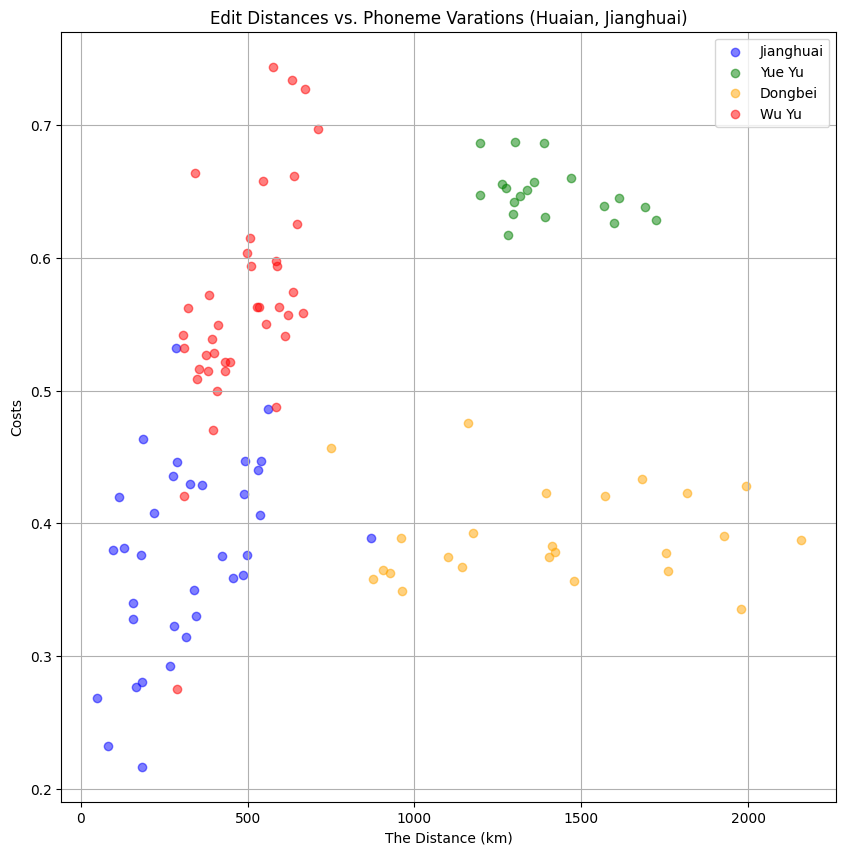

In [75]:
#淮安
num = len(phoneme2num)
index = 471
distance = dialect_km(index, language_distance)
costs = dialect_distance(all_lists[index], all_lists, num)
plot_dialect(distance, costs, indexs_list, "Edit Distances vs. Phoneme Varations (Huaian, Jianghuai)", regions_list_en)

C:\Users\hua'wei\AppData\Local\Temp\ipykernel_34156\501077807.py:23: RuntimeWarning: invalid value encountered in scalar divide
  costs[index] = costs[index]/cal_num


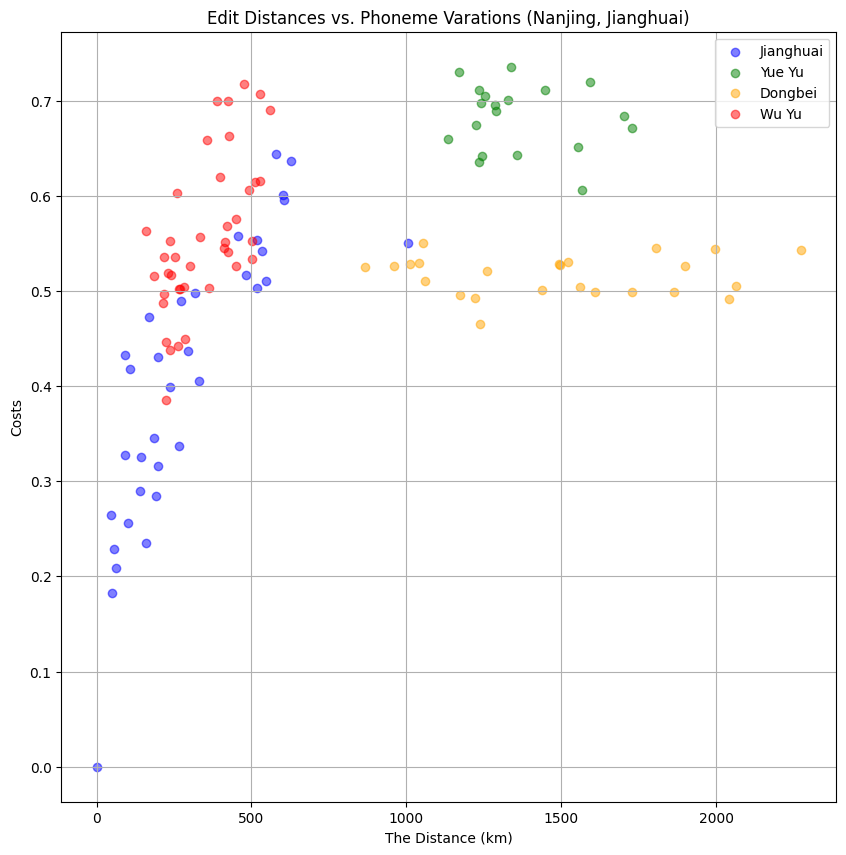

In [76]:
#南京
# language_key_dict['10G73'] #通过这个进行查找
num = len(phoneme2num)
index = 498
distance = dialect_km(index, language_distance)
costs = dialect_distance(all_lists[index], all_lists, num)
plot_dialect(distance, costs, indexs_list, "Edit Distances vs. Phoneme Varations (Nanjing, Jianghuai)", regions_list_en)

C:\Users\hua'wei\AppData\Local\Temp\ipykernel_34156\501077807.py:23: RuntimeWarning: invalid value encountered in scalar divide
  costs[index] = costs[index]/cal_num


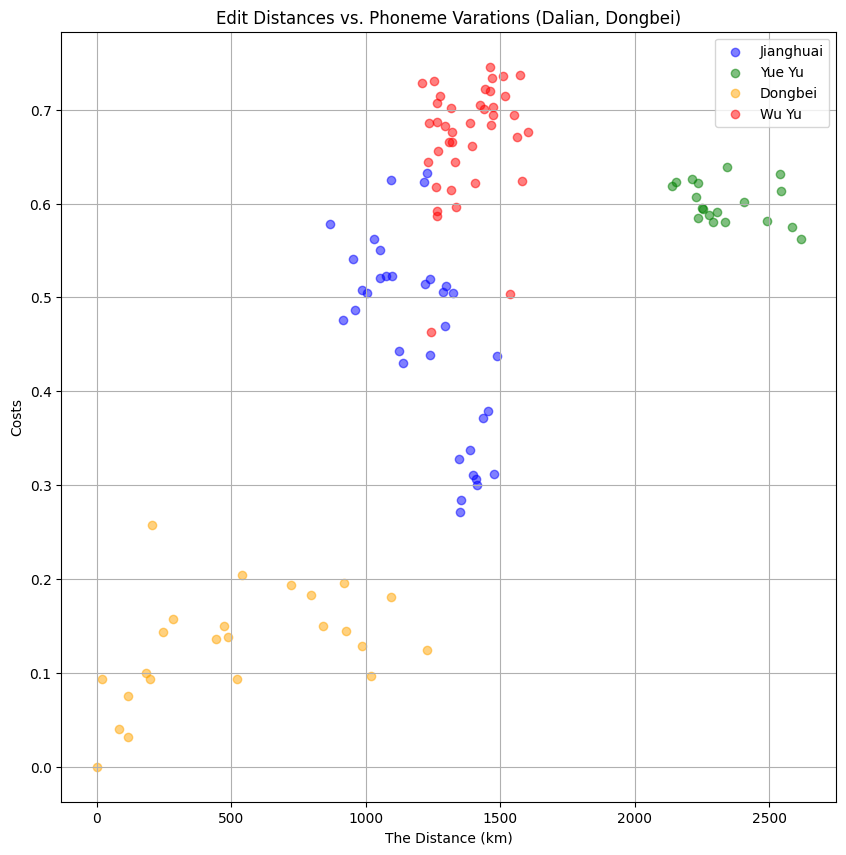

In [77]:
#大连
# language_key_dict['10G73'] #通过这个进行查找
num = len(phoneme2num)
index = 221
distance = dialect_km(index, language_distance)
costs = dialect_distance(all_lists[index], all_lists, num)
plot_dialect(distance, costs, indexs_list, "Edit Distances vs. Phoneme Varations (Dalian, Dongbei)", regions_list_en)

In [70]:
def dialect_distance(dialect, phoneme_lists, num):
    """
    计算该地区与其余所有地区的distance

    Args
    - dialect: List[List[int]]
    - phoneme_list: List[List[List[int]]]
    """

    costs = np.zeros(len(phoneme_lists))
    transition_matrix = np.ones((num+1, num+1)) - np.identity(num+1)

    for index in range(len(phoneme_lists)):
        other_dialect = phoneme_lists[index]
        cal_num = 0
        for word_index in range(len(other_dialect)):
            phonemes1, phoneme2 = dialect[word_index], other_dialect[word_index]
            if phonemes1 and phoneme2:
                length = len(phoneme2) + len(phonemes1)
                cost, new_phonemes_pairs = Levenshtein_distance(phonemes1, phoneme2, transition_matrix)
                costs[index] += cost * 2 / length
                cal_num += 1
        costs[index] = costs[index]/cal_num

    return costs

def dialect_km(dialect_index, language_distance):

    huaian_distance = np.zeros(len(language_distance))
    x1, y1 = language_distance[dialect_index][0], language_distance[dialect_index][1]

    for region_index in range(len(language_distance)):
        the_region = language_distance[region_index]

        x2, y2 = language_distance[region_index][0], language_distance[region_index][1]

        huaian_distance[region_index] = haversine_distance(y1, x1, y2, x2)
    return huaian_distance


def categroy_index(points_file, regions_list):

    df = pd.read_csv(points_file)
    indexs_list = [ [] for i in range(len(regions_list))]

    for _, row in df.iterrows():
        for flag, region in zip(range(len(regions_list)), regions_list):
            if row['point'] in language_key_dict.keys() and region == row['area']:
                    index = language_key_dict[row['point']]
                    indexs_list[flag].append(index)
    
    return indexs_list

def plot_dialect(huaian_distance, costs, indexs_list, title_text, regions_list_en):

    plt.figure(figsize=(10, 10))

    colors = ['blue', 'green', 'orange', 'red', 'purple', 'cyan']  # 每个区域对应的颜色

    for i, indices in enumerate(indexs_list):

        plt.scatter(huaian_distance[indices], (costs)[indices], color=colors[i], alpha=0.5, label=regions_list_en[i])

    plt.title(title_text)
    plt.xlabel('The Distance (km)')
    plt.ylabel('Costs')

    plt.grid(True)

    plt.legend()  # 添加图例

    # 显示图形
    plt.show()

## **2.2 Automatic Dialect Clustering**

In [92]:
def dialect_distance_selected(dialect, phoneme_lists, num, sel_indexs):
    """
    计算该地区与其余所有地区的distance

    Args
    - dialect: List[List[int]]
    - phoneme_list: List[List[List[int]]]
    - sel_indexs: List[int]
    """

    costs = np.zeros(len(sel_indexs))
    transition_matrix = np.ones((num+1, num+1)) - np.identity(num+1)

    for index_index in range(len(sel_indexs)):
        index = sel_indexs[index_index]
        other_dialect = phoneme_lists[index]
        cal_num = 0
        for word_index in range(len(other_dialect)):
            phonemes1, phoneme2 = dialect[word_index], other_dialect[word_index]
            if phonemes1 and phoneme2:
                length = len(phoneme2) + len(phonemes1)
                cost, new_phonemes_pairs = Levenshtein_distance(phonemes1, phoneme2, transition_matrix)
                costs[index_index] += cost * 2 / length
                cal_num += 1
        costs[index_index] = costs[index_index]/cal_num

    return costs

In [93]:
length_indexs_list = [len(i) for i in indexs_list] #[34, 19, 24, 40]
sel_indices = [i for indexs in indexs_list for i in indexs]

costs_matrix = np.zeros((117, 117))
for i in range(len(sel_indices)):
    costs_matrix[i] =  dialect_distance_selected(all_lists[sel_indices[i]], all_lists, num, sel_indices)

np.save('Dataset/costs_matrix.npy', costs_matrix)

In [107]:
def plot_dialect_feature(costs_2d, title_text):
    # 定义每种方言的颜色
    colors = ['blue', 'green', 'red', 'purple']
    dialect_ranges = [34, 19, 24, 40]
    dialect_labels = ['Jianghuai', 'Yue Yu', 'Dongbei', 'Wu Yu']
    color_map = np.concatenate([np.repeat(colors[i], sum(dialect_ranges[:i+1])) for i in range(len(dialect_ranges))])

    # 绘制数据点
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(dialect_labels):
        idx = sum(dialect_ranges[:i])
        plt.scatter(costs_2d[idx:idx+dialect_ranges[i], 0], costs_2d[idx:idx+dialect_ranges[i], 1], color=colors[i], label=label)

    plt.title(title_text, fontsize=20, fontweight='bold')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

d:\anaconda\envs\database\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


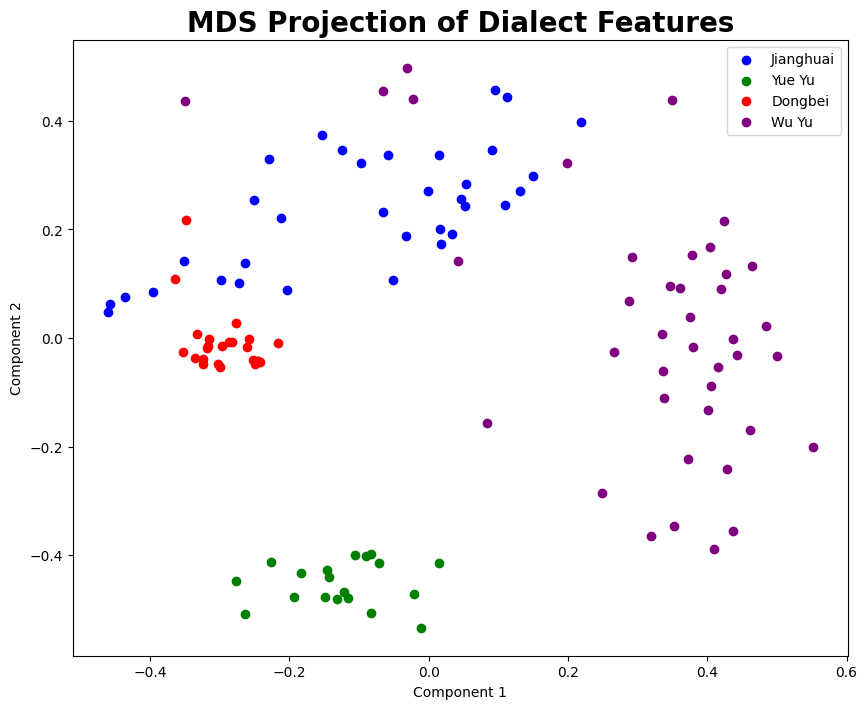

In [108]:
# costs_matrix np.array(177,177) 每一行代表一个语言特征。
# to do 1: 使用numpy将其mapping 到两维，然后绘图可视化
# ['Jianghuai', "Yue Yu", 'Dongbei', 'Wu Yu'] 为四类节点，对应有 [34, 19, 24, 40]  个，按顺序在 costs_matrix 中，即0-33个为jianghuai，后续为yue yu，可视化过程中为不同类标上不同颜色，美化可视化

# to do 2: 使用 DBSCAN 对数据进行聚类，可视化聚类结果，并且点的不同颜色分别代表['Jianghuai', "Yue Yu", 'Dongbei', 'Wu Yu'], 这样是为了看聚类结果和真实分类结果是否一致

#计算音素替换比例

#通过indexs把各个区取出来

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN
import seaborn as sns

# 创建MDS对象并将数据降到两维
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
costs_2d = mds.fit_transform(costs_matrix)

plot_dialect_feature(costs_2d, 'MDS Projection of Dialect Features')

d:\anaconda\envs\database\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


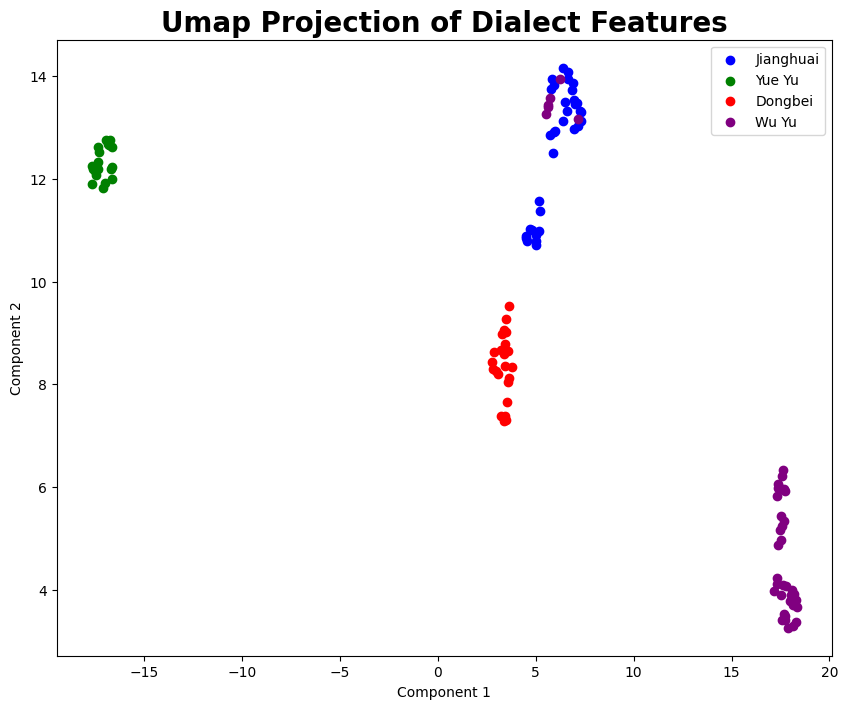

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import umap

reducer = umap.UMAP(n_neighbors=15,  # 通常的选择范围从5到50，较小的值会强调局部结构
                    min_dist=0.1,   # 最小距离，较小的值可以使聚类更紧密
                    n_components=2, # 目标低维空间的维数
                    random_state=42)

embedding = reducer.fit_transform(costs_matrix)

plot_dialect_feature(embedding, 'Umap Projection of Dialect Features')

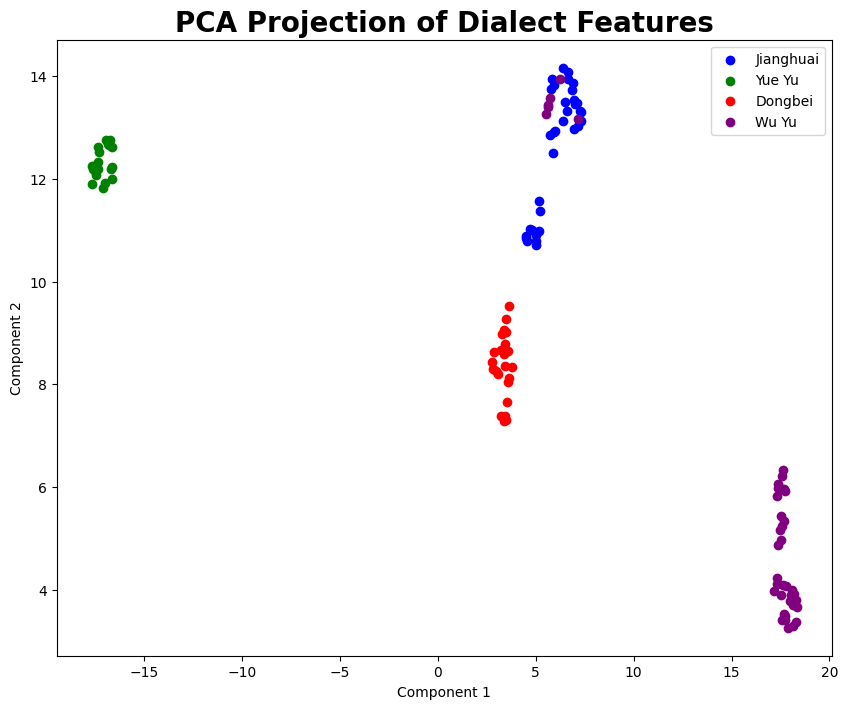

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # 降至2维

data_pca = pca.fit_transform(costs_matrix)

plot_dialect_feature(embedding, 'PCA Projection of Dialect Features')

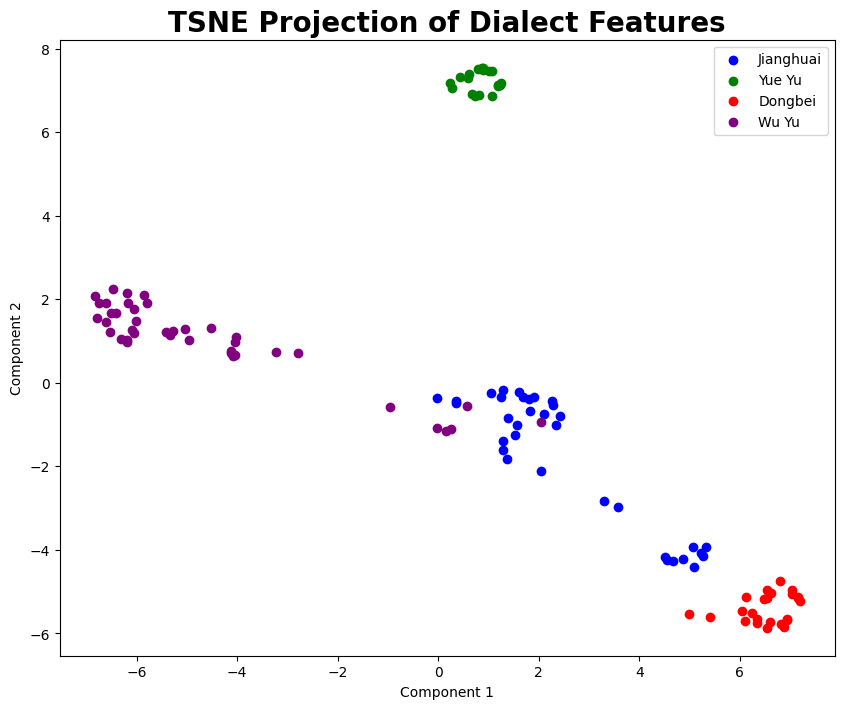

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

data_tsne = tsne.fit_transform(costs_matrix)

plot_dialect_feature(data_tsne, 'TSNE Projection of Dialect Features')


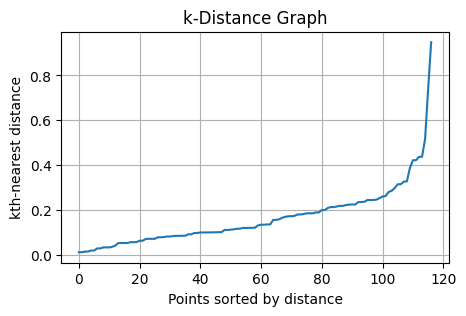

In [138]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# 假设costs_matrix是你的数据矩阵
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(reduced_data)
distances, indices = neighbors_fit.kneighbors(reduced_data)

# 排序距离
sorted_distances = np.sort(distances[:, 1], axis=0)
plt.figure(figsize=(5, 3))
plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('kth-nearest distance')
plt.title('k-Distance Graph')
plt.grid(True)
plt.show()


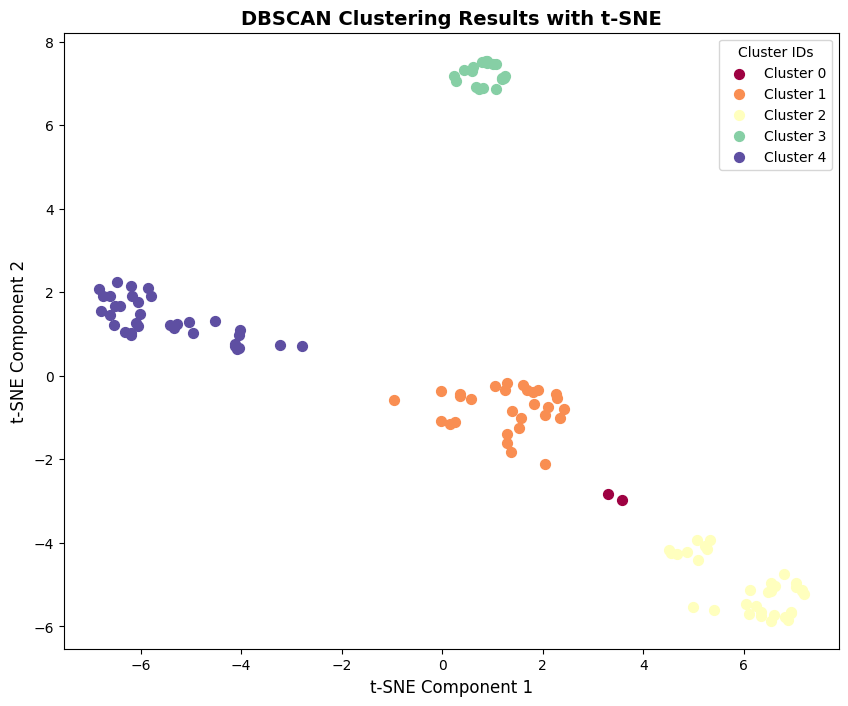

In [150]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(costs_matrix)

dbscan = DBSCAN(eps=1.4, min_samples=2)
clusters = dbscan.fit_predict(reduced_data)

# 绘制聚类结果
plt.figure(figsize=(10, 8))

# 为每个聚类分配不同的颜色
unique_clusters = np.unique(clusters)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    if cluster == -1:  # -1 表示噪声点
        color = 'k'  # 将噪声点设置为黑色
    mask = clusters == cluster
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], s=50, c=[color], label=f'Cluster {cluster}' if cluster != -1 else 'Noise')

plt.title('DBSCAN Clustering Results with t-SNE', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Cluster IDs')
plt.show()

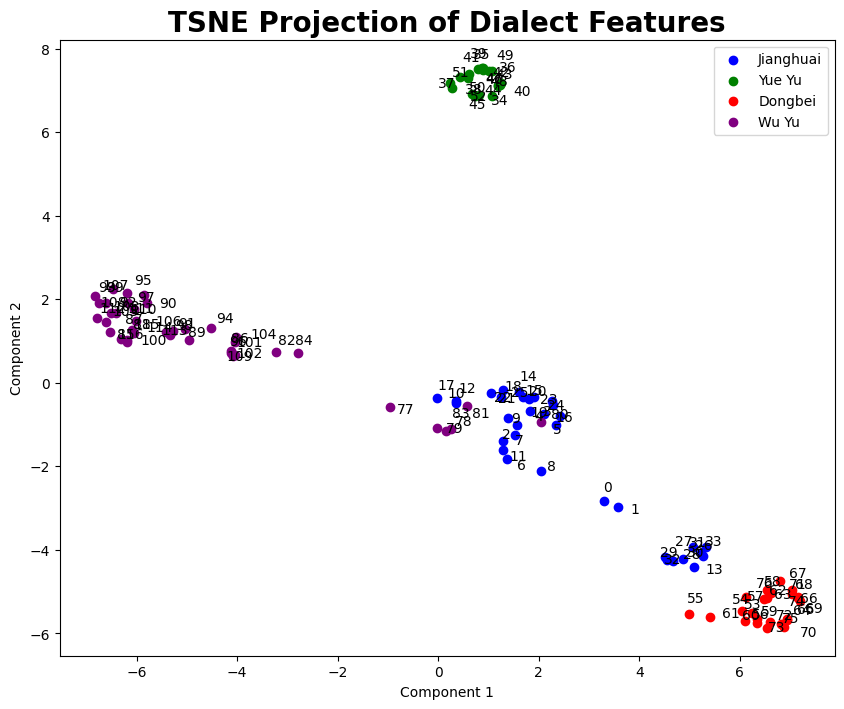

In [175]:
#进一步观察标记错的点

import random

def plot_dialect_feature_label(costs_2d, title_text):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    # 定义每种方言的颜色
    colors = ['blue', 'green', 'red', 'purple']
    dialect_ranges = [34, 19, 24, 40]
    dialect_labels = ['Jianghuai', 'Yue Yu', 'Dongbei', 'Wu Yu']
    color_map = np.concatenate([np.repeat(colors[i], sum(dialect_ranges[:i+1])) for i in range(len(dialect_ranges))])

    # 绘制数据点
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(dialect_labels):
        
        idx = sum(dialect_ranges[:i])
        plt.scatter(costs_2d[idx:idx+dialect_ranges[i], 0], costs_2d[idx:idx+dialect_ranges[i], 1], color=colors[i], label=label)
        # 在每个点的附近显示位置
        for j, (x, y) in enumerate(zip(costs_2d[idx:idx+dialect_ranges[i], 0], costs_2d[idx:idx+dialect_ranges[i], 1])):
            offset_x = random.uniform(-0.3, 0.3)  # 随机X轴偏移量
            offset_y = random.uniform(-0.3, 0.3)  # 随机Y轴偏移量
            plt.text(x + offset_x, y + offset_y, str(idx + j), fontsize=10, color='black')

    plt.title(title_text, fontsize=20, fontweight='bold')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

# 假设你已经定义了 costs_matrix
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(costs_matrix)

plot_dialect_feature_label(data_tsne, 'TSNE Projection of Dialect Features')


In [176]:
length_indexs_list = [len(i) for i in indexs_list] #[34, 19, 24, 40]
sel_indices = [i for indexs in indexs_list for i in indexs]

wrong_list = [77, 81, 80, 78, 79 ,83]
prior_num = 34 + 19 + 24
wrong_list_ = [i - prior_num for i in wrong_list]
wrong_list_

def categroy_index(points_file, regions_list):

    
    indexs_list = [ [] for i in range(len(regions_list))]

    
    
    return indexs_list

[0, 4, 3, 1, 2, 6]

In [179]:
df = pd.read_csv(points_file)
a = [0, 4, 3, 1, 2, 6]
w = []
flag = 0
for _, row in df.iterrows():
        if row['point'] in language_key_dict.keys() and '吴语' == row['area']:
                if flag in a:
                        w.append(row['point'])
                        print(row['point'])
                flag += 1
print(w)

18940
21J02
21E58
21E49
21E53
21A30
['18940', '21J02', '21E58', '21E49', '21E53', '21A30']


In [ ]:
wrong_list = [77, 81, 80, 78, 79 ,83]
cross_pond = [18940, 21E49, 21E53, 21J02, 21E58, 21A30]

# 77,江西,上饶市,信州区,东市街道,吴语,处衢片,龙衢小片,117.92,28.43
# 81,安徽,芜湖,繁昌,繁阳,吴语,宣州,铜泾,118.2054243183,31.107958593
# 80,安徽,芜湖,南陵,籍山,吴语,宣州,铜泾,118.225,30.9
# 78,安徽,黄山市,黄山区,甘棠镇,吴语,宣州,太高,118.09166666666667,30.266666666666666
# 79,安徽,铜陵市,义安区,五松镇,吴语,宣州片,铜泾小片,117.93416666666667,30.942777777777778
# 83,安徽,铜陵市,义安区,五松镇,吴语,宣州片,铜泾小片,118.18333333333334,30.941666666666666

## **2.3 Relationship between Initials, Finals and Tones**

<img src="image/Gold.png" />

In [214]:
# 分别计算overal, initial, final 和 声调的关联

#first 计算三个
costs_matrix_initial= np.zeros((117, 117))
costs_matrix_final = np.zeros((117, 117))
costs_matrix_tone = np.zeros((117, 117))


length_indexs_list = [len(i) for i in indexs_list] #[34, 19, 24, 40]
sel_indices = [i for indexs in indexs_list for i in indexs]

# initials_lists, finals_lists, all_lists, tones_lists

for i in range(len(sel_indices)):
    # costs_matrix[i] =  dialect_distance_selected(all_lists[sel_indices[i]], all_lists, num, sel_indices)
    costs_matrix_initial[i]=  dialect_distance_selected(initials_lists[sel_indices[i]], initials_lists, num, sel_indices)
    costs_matrix_final[i] =  dialect_distance_selected(finals_lists[sel_indices[i]], finals_lists, num, sel_indices)

In [ ]:
np.save('Dataset/costs_matrix_initial.npy', costs_matrix_initial)
np.save('Dataset/costs_matrix_final.npy', costs_matrix_final)
np.save('Dataset/costs_matrix_tones.npy', costs_matrix_tone)

In [249]:
for i in range(len(sel_indices)):
    costs_matrix_tone[i]=  dialect_tone(tones_lists[sel_indices[i]], tones_lists, sel_indices)

### Calculate the Spearman Cofficient

In [250]:
import numpy as np
from scipy.stats import spearmanr
from prettytable import PrettyTable

def calculate_spearman(array1, array2, array3, array4, title1, title2, title3, title4):
    # 计算Spearman系数
    spearman_12, _ = spearmanr(array1, array2)
    spearman_13, _ = spearmanr(array1, array3)
    spearman_14, _ = spearmanr(array1, array4)
    spearman_23, _ = spearmanr(array2, array3)
    spearman_24, _ = spearmanr(array2, array4)
    spearman_34, _ = spearmanr(array3, array4)
    
    # 创建表格并添加数据
    table = PrettyTable()
    table.field_names = ["Comparison", "Spearman Correlation Coefficient"]
    table.add_row([f"{title1} vs {title2}", f"{spearman_12:.2f}"])
    table.add_row([f"{title1} vs {title3}", f"{spearman_13:.2f}"])
    table.add_row([f"{title1} vs {title4}", f"{spearman_14:.2f}"])
    table.add_row([f"{title2} vs {title3}", f"{spearman_23:.2f}"])
    table.add_row([f"{title2} vs {title4}", f"{spearman_24:.2f}"])
    table.add_row([f"{title3} vs {title4}", f"{spearman_34:.2f}"])
    
    # 输出结果
    print(table)

In [251]:
# 通过计算 initials_lists, finals_lists, all_lists, tones_lists 四者的spearman cofficient，观察这种变化是不是同步的

# 1. 全部transfer成一维，然后对比
i, j, k, z = costs_matrix_initial.flatten(),  costs_matrix_final.flatten(),  costs_matrix.flatten(), costs_matrix_tone.flatten()
calculate_spearman(i, j, k, z, 'Initials', 'Finals', 'Alls','Tones')

+--------------------+----------------------------------+
|     Comparison     | Spearman Correlation Coefficient |
+--------------------+----------------------------------+
| Initials vs Finals |               0.57               |
|  Initials vs Alls  |               0.84               |
| Initials vs Tones  |               0.24               |
|   Finals vs Alls   |               0.91               |
|  Finals vs Tones   |               0.24               |
|   Alls vs Tones    |               0.25               |
+--------------------+----------------------------------+


In [252]:
# 2. 分别保留group内的，对比

def sel_cost(start, length):
    return costs_matrix_initial[start:start+length, start:start+length].flatten(),  costs_matrix_final[start:start+length, start:start+length].flatten(),  costs_matrix[start:start+length, start:start+length].flatten(), costs_matrix_tone[start:start+length, start:start+length].flatten()

dialect_ranges = [34, 19, 24, 40]
dialect_labels = ['Jianghuai', 'Yue Yu', 'Dongbei', 'Wu Yu']

start = 0
for index in dialect_ranges:
    i, j, k, z = sel_cost(start, index)
    start += index
    calculate_spearman(i, j, k, z, 'Initials', 'Finals', 'Alls','Tones')

+--------------------+----------------------------------+
|     Comparison     | Spearman Correlation Coefficient |
+--------------------+----------------------------------+
| Initials vs Finals |               0.47               |
|  Initials vs Alls  |               0.69               |
| Initials vs Tones  |               0.28               |
|   Finals vs Alls   |               0.95               |
|  Finals vs Tones   |               0.38               |
|   Alls vs Tones    |               0.38               |
+--------------------+----------------------------------+
+--------------------+----------------------------------+
|     Comparison     | Spearman Correlation Coefficient |
+--------------------+----------------------------------+
| Initials vs Finals |               0.57               |
|  Initials vs Alls  |               0.86               |
| Initials vs Tones  |               0.68               |
|   Finals vs Alls   |               0.90               |
|  Finals vs T

In [255]:
dialect_ranges = [34, 19, 24, 40]
dialect_labels = ['Jianghuai', 'Yue Yu', 'Dongbei', 'Wu Yu']

print(np.mean(costs_matrix_initial.flatten()), np.mean(costs_matrix_final.flatten()))
start = 0
for index in dialect_ranges:
    i, j, k, z = sel_cost(start, index)
    print(np.mean(i), np.mean(j))

0.3866105618242373 0.6647026100162553
0.20101922018734752 0.5394837120949924
0.17349189920987299 0.5385845125392404
0.16702875146152169 0.525028003000379
0.28528671194928296 0.597917691789005


In [279]:
import numpy as np
from sklearn.linear_model import LinearRegression

def r_squared(x, y):
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # 创建一个线性回归模型
    model = LinearRegression()

    # 拟合模型
    model.fit(x, y)

    # 计算R²
    r_squared = model.score(x, y)
    # print("R-squared:", r_squared)
    return r_squared, 0

In [281]:
# 2. 分别保留group内的，对比
i, j, k, z = costs_matrix_initial.flatten(),  costs_matrix_final.flatten(),  costs_matrix.flatten(), costs_matrix_tone.flatten()
calculate_R(i, j, k, z, 'Initials', 'Finals', 'Alls','Tones')

def sel_cost(start, length):
    return costs_matrix_initial[start:start+length, start:start+length].flatten(),  costs_matrix_final[start:start+length, start:start+length].flatten(),  costs_matrix[start:start+length, start:start+length].flatten(), costs_matrix_tone[start:start+length, start:start+length].flatten()

dialect_ranges = [34, 19, 24, 40]
dialect_labels = ['Jianghuai', 'Yue Yu', 'Dongbei', 'Wu Yu']

start = 0
for index in dialect_ranges:
    i, j, k, z = sel_cost(start, index)
    start += index
    calculate_R(i, j, k, z, 'Initials', 'Finals', 'Alls','Tones')

+--------------------+----------+
|     Comparison     | R Square |
+--------------------+----------+
| Initials vs Finals |   0.40   |
|  Initials vs Alls  |   0.70   |
| Initials vs Tones  |   0.12   |
|   Finals vs Alls   |   0.91   |
|  Finals vs Tones   |   0.19   |
|   Alls vs Tones    |   0.19   |
+--------------------+----------+
+--------------------+----------+
|     Comparison     | R Square |
+--------------------+----------+
| Initials vs Finals |   0.24   |
|  Initials vs Alls  |   0.52   |
| Initials vs Tones  |   0.12   |
|   Finals vs Alls   |   0.92   |
|  Finals vs Tones   |   0.21   |
|   Alls vs Tones    |   0.22   |
+--------------------+----------+
+--------------------+----------+
|     Comparison     | R Square |
+--------------------+----------+
| Initials vs Finals |   0.37   |
|  Initials vs Alls  |   0.76   |
| Initials vs Tones  |   0.47   |
|   Finals vs Alls   |   0.83   |
|  Finals vs Tones   |   0.46   |
|   Alls vs Tones    |   0.57   |
+-------------

In [280]:
import numpy as np
from scipy.stats import spearmanr
from prettytable import PrettyTable

def calculate_R(array1, array2, array3, array4, title1, title2, title3, title4):
    # 计算Spearman系数
    spearman_12, _ = r_squared(array1, array2)
    spearman_13, _ = r_squared(array1, array3)
    spearman_14, _ = r_squared(array1, array4)
    spearman_23, _ = r_squared(array2, array3)
    spearman_24, _ = r_squared(array2, array4)
    spearman_34, _ = r_squared(array3, array4)
    
    # 创建表格并添加数据
    table = PrettyTable()
    table.field_names = ["Comparison", "R Square"]
    table.add_row([f"{title1} vs {title2}", f"{spearman_12:.2f}"])
    table.add_row([f"{title1} vs {title3}", f"{spearman_13:.2f}"])
    table.add_row([f"{title1} vs {title4}", f"{spearman_14:.2f}"])
    table.add_row([f"{title2} vs {title3}", f"{spearman_23:.2f}"])
    table.add_row([f"{title2} vs {title4}", f"{spearman_24:.2f}"])
    table.add_row([f"{title3} vs {title4}", f"{spearman_34:.2f}"])
    
    # 输出结果
    print(table)

In [248]:
# find the code for calculating tones

import torch
save_path = 'Dataset/simi_area_quadratic.pt'
Simi_recti = torch.load(save_path)
Simi_recti[1,2,0,2,1,0]


def dialect_tone(dialect, phoneme_lists, sel_indexs):
    """
    dialect: List[List[int]]
    """
    costs = np.zeros(len(sel_indexs))

    for index_index in range(len(sel_indexs)):
        index = sel_indexs[index_index]
        other_dialect = phoneme_lists[index] #List[List[int]]
        cal_num = 0
        for word_index in range(len(other_dialect)):
            phonemes1, phoneme2 = dialect[word_index], other_dialect[word_index] 
            if len(phonemes1) >= 2 and len(phoneme2) >= 2:
                p1, p2 = pad_to_length_three(phonemes1), pad_to_length_three(phoneme2)
                a1, a2, a3, a4, a5, a6 = p1[0],p1[1],p1[2],p2[0],p2[1],p2[2]
                # print(a1, a2, a3, a4, a5, a6)
                cost = Simi_recti[a1, a2, a3, a4, a5, a6]
                costs[index_index] += cost 
                cal_num += 1

        costs[index_index] = costs[index_index]/cal_num

    return costs

def pad_to_length_three(input_list):
    padding_count = 3 - len(input_list)
    padded_list = input_list + [0] * padding_count
    return padded_list
